<a href="https://colab.research.google.com/github/eromoegbejule/06-homework-submission-repository/blob/main/Egbejule_Training_a_facial_recognition_system_(Homework%2C_Part_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A custom facial recognition system

Once upon a time the NYT [built a system to recognize members of Congress](https://open.nytimes.com/how-the-new-york-times-uses-software-to-recognize-members-of-congress-29b46dd426c7). If they can do it, why not us?

## Obtaining the data

To train a model to recognize members of Congress, we need *labeled pictures of members of Congress.* Luckily I spent a million years doing that for you!

Since I haven't memorized everyone in Congress, I started with a [a list of members of legislators downloaded from GitHub](https://github.com/unitedstates/congress-legislators).

In [9]:
import pandas as pd
df = pd.read_csv("https://theunitedstates.io/congress-legislators/legislators-current.csv")
df.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,senate_class,party,url,address,phone,contact_form,rss_url,twitter,facebook,youtube,youtube_id,bioguide_id,thomas_id,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,NaN,NaN,NaN,Sherrod Brown,1952-11-09,M,sen,OH,NaN,1.0,Democrat,https://www.brown.senate.gov,503 Hart Senate Office Building Washington DC ...,202-224-2315,http://www.brown.senate.gov/contact/,http://www.brown.senate.gov/rss/feeds/?type=al...,SenSherrodBrown,SenatorSherrodBrown,SherrodBrownOhio,UCgy8jfERh-t_ixkKKoCmglQ,B000944,136.0,N00003535,S307,"H2OH13033,S6OH00163",5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown
1,Cantwell,Maria,NaN,NaN,NaN,Maria Cantwell,1958-10-13,F,sen,WA,NaN,1.0,Democrat,https://www.cantwell.senate.gov,511 Hart Senate Office Building Washington DC ...,202-224-3441,http://www.cantwell.senate.gov/public/index.cf...,http://www.cantwell.senate.gov/public/index.cf...,SenatorCantwell,senatorcantwell,SenatorCantwell,UCN52UDqKgvHRk39ncySrIMw,C000127,172.0,N00007836,S275,"S8WA00194,H2WA01054",26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell
2,Cardin,Benjamin,L.,NaN,NaN,Benjamin L. Cardin,1943-10-05,M,sen,MD,NaN,1.0,Democrat,https://www.cardin.senate.gov,509 Hart Senate Office Building Washington DC ...,202-224-4524,http://www.cardin.senate.gov/contact/,http://www.cardin.senate.gov/rss/feeds/?type=all,SenatorCardin,senatorbencardin,senatorcardin,UCiQaJnMzlfzzG3VESgyZChA,C000141,174.0,N00001955,S308,"H6MD03177,S6MD03177",4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin
3,Carper,Thomas,Richard,NaN,NaN,Thomas R. Carper,1947-01-23,M,sen,DE,NaN,1.0,Democrat,https://www.carper.senate.gov/public,513 Hart Senate Office Building Washington DC ...,202-224-2441,http://www.carper.senate.gov/public/index.cfm/...,http://www.carper.senate.gov/public/index.cfm/...,SenatorCarper,tomcarper,senatorcarper,UCgLnvbKwu4B3navofj6Qvvw,C000174,179.0,N00012508,S277,S8DE00079,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper
4,Casey,Robert,P.,Jr.,Bob,"Robert P. Casey, Jr.",1960-04-13,M,sen,PA,NaN,1.0,Democrat,https://www.casey.senate.gov,393 Russell Senate Office Building Washington ...,202-224-6324,https://www.casey.senate.gov/contact/,http://www.casey.senate.gov/rss/feeds/?all,SenBobCasey,SenatorBobCasey,SenatorBobCasey,UCtVssXhx-KuZa-hSvnsnJ0A,C001070,1828.0,N00027503,S309,S6PA00217,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.


For each row, I combined their first and last name and used [Google Images Downloader](https://github.com/hardikvasa/google-images-download) to search Google Image Search for their name and download 30 images. Each image is stored in a folder named after the Congressperson.

```
downloads/
├─ congressperson_xyz/
│  ├─ 1.jpg
│  ├─ 2.jpg
│  ├─ 3.jpg
├─ congressperson_abc/
   ├─ 1.jpg
   ├─ 2.jpg
   ├─ 3.jpg
...
```
That ended up with about 8GB of images, which I then resized using [ImageMagick](https://imagemagick.org/) to a max size of 1080x1080. I guess some of the pictures were very high-res, that got us down to around 2GB.

### Just the faces, please

Since human beings change their clothes each day, the *face* is the thing that allows us to tell different people apart. So I then ran each image through [MTCNN](https://github.com/ipazc/mtcnn) to cut out the faces and save them separately. So if we had an image with four faces in it, now we have four separate images instead.

For a single member of Congress, all of the faces we found in all of the images of them are stored in a folder named after them.

```
faces/
├─ congressperson_xyz/
│  ├─ 1_face0.jpg
│  ├─ 1_face1.jpg
│  ├─ 2_face0.jpg
│  ├─ 3_face0.jpg
│  ├─ 3_face1.jpg
│  ├─ 3_face2.jpg
├─ congressperson_abc/
   ├─ 1_face0.jpg
   ├─ 2_face0.jpg
   ├─ 2_face1.jpg
   ├─ 3_face0.jpg
...
```

## Pull in the data

Start by downloading [faces.zip](https://drive.google.com/file/d/1-26HtaU6_PfJm-FizHSgJpUh_KRPO60S/view?usp=sharing), then uploading it to your Google Drive.

Then, to import the data into this notebook, we'll need to connect Google Colab to Google Drive.

In [10]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


This code connects our Google Drive to the `gdrive` folder. The actual contents of your Google Drive will be in `grdrive/MyDrive`.

Now we can copy `faces.zip` over and unzip it.

In [11]:
# Copy faces.zip into the current folder
!cp /content/gdrive/MyDrive/faces.zip .

# Unzip it
!unzip faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: faces/antonio_delgado/0_face_16.antonio_delgado_apfilejpg.jpg  
  inflating: faces/antonio_delgado/0_face_2.imkyeto0_400x400.jpg  
  inflating: faces/antonio_delgado/0_face_20.44920421_634056873657629_211051553304346624_n.jpg  
  inflating: faces/antonio_delgado/0_face_15.screen_shot_2018_07_18_at_9.23.24_am.0.png.jpg  
  inflating: faces/antonio_delgado/3_face_25.70b8abf6168d2345-1495034871082.jpg  
  inflating: faces/antonio_delgado/1_face_17.180511_antonio_delgado_0725-1145x700.jpg  
  inflating: faces/antonio_delgado/0_face_17.180511_antonio_delgado_0725-1145x700.jpg  
  inflating: faces/antonio_delgado/7_face_23.img_0105.jpeg  
  inflating: faces/antonio_delgado/1_face_13.delgado-e1541470468313-1024x640.jpg  
  inflating: faces/antonio_delgado/3_face_21.im-245737.jpg  
  inflating: faces/antonio_delgado/0_face_10.img_8096.jpg  
  inflating: faces/antonio_delgado/0_face_29.02faso-delgado1-articlelarge-v2.jpg  
   creat

After you run the code below, click the little folder icon on the left-hand side of the screen. You can browse around and see what files came out of it! You probably need to click the little folder refresh icon, too.

## Looking at the images

If you want to look at the images, you can use this code. It picks 16 random ones and displays them in a grid. **If you're feeling lazy, just continue onward without doing it!!!**

```python
import glob
import random
import matplotlib.pyplot as plt

# Get a list of all files
filenames = glob.glob("faces/**/*")

# Let's look at them!!!
plt.figure(figsize=(10, 10))
for i, filename in enumerate(random.sample(filenames, 16)):
  ax = plt.subplot(4, 4, i + 1)
  img = plt.imread(filename)
  plt.imshow(img)
  plt.title(filename.split("/")[1])
  plt.axis("off")
```

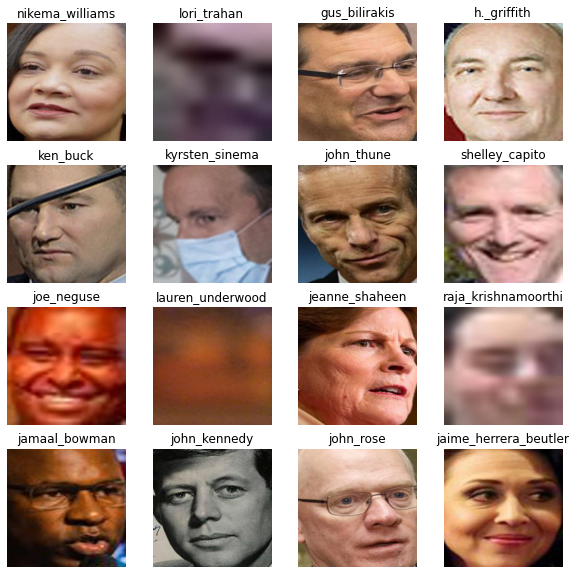

In [12]:
## Looking at the images
import glob
import random
import matplotlib.pyplot as plt
 
# Get a list of all files
filenames = glob.glob("faces/**/*")
 
# Let's look at them!!!
plt.figure(figsize=(10, 10))
for i, filename in enumerate(random.sample(filenames, 16)):
  ax = plt.subplot(4, 4, i + 1)
  img = plt.imread(filename)
  plt.imshow(img)
  plt.title(filename.split("/")[1])
  plt.axis("off")

# Now, machine learning!

## Tensorflow setup

Let's start by importing Tensorflow and whatever else we might need.

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

So far our images have always been RGB and sized 224x224, so that's what we're going to stick with again. We use 224x224 because the networks we've seen are trained with that size, so it's the only size image they can understand!

> Note: It isn't *all* networks that need 224x224, just the ones we've looked at so far.

**Update `IMAGE_SIZE` to reflect the size image our neural network will want.**

In [15]:
# Magic numbers for success
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

## Loading our data

When we did classification in class, we used `tf.keras.preprocessing.image_dataset_from_directory` to, well, load an image dataset from a directory! Since nothing can ever be simple, there are a hundred other ways to do it, too.

This time we're going to use `flow_from_directory` instead. It works almost exactly the same, but it's more efficient if you need to do things like change `0-255` to `0-1` or perform image augmentations to get rotated/zoomed/flipped versions of your photos. Which I guess we do?

**Change `data_dir` to point at to the folder that contains our images.**

In [16]:
# Magic code for success
data_dir = 'faces'
datagen_kwargs = dict(rescale=1./255, validation_split=.10)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, interpolation="bilinear", class_mode='sparse')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2,
    **datagen_kwargs)

train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 2777 images belonging to 536 classes.
Found 27391 images belonging to 536 classes.


The output should look like this:

```
Found 2777 images belonging to 536 classes.
Found 27391 images belonging to 536 classes.
```

## Building our model

In class, we tried two approaches to building an image classifier:

1. Use ImageNet's pre-trained 1,000 categories to figure out what was in images
2. Use our own custom network and some custom images we downloaded to train a brand-new model

It turns out there's also a third approach, where you **start with a model that knows about some things, but then you teach it to recognize new things.** This is called **transfer learning.**

Transfer learning is useful because the model probably already knows about color and lines and circles and eyeballs and hair, which is how it knows a dog is different from an airplane. We just say hey, use what you know about color and lines and circles and eyeballs and hair to tell different people apart instead of dogs and planes!

## Selecting a pre-trained model and architecture

Below you have **three options** of models that you can start from.

1. **MobileNet:** A network that is optimized for size, and so it's easier to transfer to mobile devices
2. **ResNet 50:** A 50-layer residual network
3. **ResNet 101:** A 101-layer residual network (like ResNet 50, just bigger)

The difference is the "magic insides" that go between the inputs and the outputs - we don't understand what the insides are, but we still have to make a choice. They've all been trained on ImageNet, so they should in theory all know basically the same stuff.

**Pick a pre-trained model by uncommenting one of the lines below, then running the cell.** If you want, you can read about them by visiting the URL in your browser.

In [18]:
base_model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
base_model_url = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
base_model_url = "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5"

# download the model from 
pretrained_model = hub.KerasLayer(base_model_url, trainable=False)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    pretrained_model,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              42626560  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 536)               1098264   
Total params: 43,724,824
Trainable params: 1,098,264
Non-trainable params: 42,626,560
_________________________________________________________________


Remember: we're using a **softmax** layer at the end because we want probabilities! Softmax = probabilities!!!

## Settings for training our model

Before we train, we need to `.compile` our model. Which I guess is just some sort of setup? It doesn't matter what it is, we just have to do it!!

**Optimizer:** Our optimizer is `adam`, because that's... what people always use. Not *always* always, but since we don't even know what an optimizer is who cares.

**Loss:** We're trying to predict categories, so our loss is either going to be `SparseCategoricalCrossentropy()` or `CategoricalCrossentropy()`. We aren't the first people to be confused about this, so maybe [read this question and answer](https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy) and try the one you think makes the most sense.

**Metrics:** We want to make our classifier accurate, so our metric is... `accuracy`.

**Set the appropriate loss function below.**

In [21]:
model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

## Training the model

Here we go!!! Let's do it!!!

**Pick the number of epochs you want to train for.** It's going to be a tradeoff between accuracy and how long it takes! Right now I have it set for a single epoch, which is definitely not enough.

> If it's taking a really long time to train an epoch (more than 5-10 minutes), we want to make sure you're using the GPU! Click **Runtime** at the top of the screen, then **Change runtime type** and change **Hardware accelerator** to **GPU**. This will make everything faster.

Even though Google Colab will let you run this for up to 12 hours, for this exercise I recommend not going any longer than an hour.

In [22]:
num_epochs = 3

# This is a little more complicated than in class because we
# are using that 'flow' loader instead of the 'images' loader
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps)

Epoch 1/3
855/855 [==============================] - 380s 400ms/step - loss: 6.7814 - accuracy: 0.0148 - val_loss: 5.3714 - val_accuracy: 0.0887
Epoch 2/3
855/855 [==============================] - 340s 398ms/step - loss: 5.4884 - accuracy: 0.0723 - val_loss: 5.0918 - val_accuracy: 0.1159
Epoch 3/3
855/855 [==============================] - 339s 396ms/step - loss: 5.0448 - accuracy: 0.1144 - val_loss: 4.8884 - val_accuracy: 0.1439


## Your results

How did it do?

`accuracy` is a measure of how good your model is at things it's already seen (e.g. the "train" part of train/test split) and `val_accuracy` is a measure of how good it is at things it *hasn't* seen (e.g. the "test" part of train/test split).

**Paste the last couple line of output into the cell below.** It should look something like this:

```python
# Epoch 2/2
# 855/855 [==============================] - 299s 349ms/step - loss: 5.5293 - accuracy: 0.0758 - val_loss: 5.1483 - val_accuracy: 0.1101
```

After pasting, comment them out so it doesn't try to run them!

In [23]:
# Epoch 3/3
# 855/855 [==============================] - 339s 396ms/step - loss: 5.0448 - accuracy: 0.1144 - val_loss: 4.8884 - val_accuracy: 0.1439#

## Save your model to Google Drive

Instead of downloading our model, we'll just save it to our Google Drive. Since we don't have a GPU at home (right?? we're on a laptop??), it would probably run too slowly on our machine anyway.

In [24]:
# Make a new folder called "models" on our drive
!mkdir -p /content/gdrive/MyDrive/models/face_recognition_v1

# Save the model to that folder
model.save('/content/gdrive/MyDrive/models/face_recognition_v1')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/face_recognition_v1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/face_recognition_v1/assets


We also need to save the names of everyone, because the model only knows numbers! Person 0, Person 1, Person 2, etc.

In [25]:
class_names = list(train_generator.class_indices.keys())
class_names[:5]

['a._ferguson',
 'a._mceachin',
 'abigail_spanberger',
 'adam_kinzinger',
 'adam_schiff']

In [27]:
import json

with open('/content/gdrive/MyDrive/models/congress_labels.json', 'w') as fp:
  json.dump(class_names, fp)

# Trying another model

We're going to try another model instead of whatever you picked above. **And this time I'm telling you which one to use.** Our new model is built on ResNet50, but it can't tell a dog from an airplane!

It turns out *there are other image classification datasets out there besides ImageNet!* Some of them are specific to things like cancerous cells or handwritten numbers, but we're going to make use of one that's all about **telling different faces apart.**

There are a lot of options for "standard datasets" for training facial recognition systems. Some are based on random faces from the internet (FaceNet and VGGFace), while others are based on *just celebrities* (CelebNet, which seems kind of weird, honestly). There are probably other ones with mug shots and stuff, too.

VGGFace2 is probably the most popular dataset these days, but I couldn't find a pre-trained VGGFace2 model that could easily work with Tensorflow 2! So instead we're going to use [a ResNet50 trained with FaceNet](https://github.com/nyoki-mtl/keras-facenet) by Hiroki Taniai, adapted for Tensorflow 2 by [Rajan Ghimire](https://github.com/R4j4n/Face-recognition-Using-Facenet-On-Tensorflow-2.X).

In short: **we're using some random face-trained model from the internet instead of one trained on ImageNet.**

## Defining the model

Once upon a time we wrote our own model. It looked something like this:

```python
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMAGE_SHAPE),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names), activation='softmax')
])
```

That was a baby model for little babies. In order to use FaceNet, we need to grow up a little!

Our new model is in the cell below. **Run it.**

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, Input, Add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Lambda, add, GlobalAveragePooling2D, Convolution2D, LocallyConnected2D, ZeroPadding2D, concatenate, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K


def scaling(x, scale):
	return x * scale

def InceptionResNetV2():
	inputs = Input(shape=(160, 160, 3))
	x = Conv2D(32, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_1a_3x3') (inputs)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_1a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_1a_3x3_Activation')(x)
	x = Conv2D(32, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_2a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2a_3x3_Activation')(x)
	x = Conv2D(64, 3, strides=1, padding='same', use_bias=False, name= 'Conv2d_2b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2b_3x3_Activation')(x)
	x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
	x = Conv2D(80, 1, strides=1, padding='valid', use_bias=False, name= 'Conv2d_3b_1x1') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_3b_1x1_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_3b_1x1_Activation')(x)
	x = Conv2D(192, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_4a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4a_3x3_Activation')(x)
	x = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_4b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4b_3x3_Activation')(x)
	
	# 5x Block35 (Inception-ResNet-A block):
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_1_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_1_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_2_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_2_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_3_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_3_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_4_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_4_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_5_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_5_Activation')(x)

	# Mixed 6a (Reduction-A block):
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_0_Conv2d_1a_3x3') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_6a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_6a_Branch_2_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_pool]
	x = Concatenate(axis=3, name='Mixed_6a')(branches)

	# 10x Block17 (Inception-ResNet-B block):
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_1_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_1_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_2_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_2_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_3_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_3_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_4_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_4_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_5_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_5_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_6_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_6_Activation')(x)	
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_7_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_7_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_7_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_7_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_8_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_8_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_8_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_8_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_9_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_9_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_9_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_9_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_10_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_10_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_10_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_10_Activation')(x)

	# Mixed 7a (Reduction-B block): 8 x 8 x 2080	
	branch_0 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_0a_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_0a_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_0a_1x1_Activation')(branch_0)
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_1a_3x3') (branch_0)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_2 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_1a_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_1a_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_1a_3x3_Activation')(branch_2)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_7a_Branch_3_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_2, branch_pool]
	x = Concatenate(axis=3, name='Mixed_7a')(branches)

	# 5x Block8 (Inception-ResNet-C block):
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_1_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_1_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_2_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_2_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_3_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_3_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_4_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_4_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_5_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_5_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_6_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 1})(up)
	x = add([x, up])
	
	# Classification block
	x = GlobalAveragePooling2D(name='AvgPool')(x)
	x = Dropout(1.0 - 0.8, name='Dropout')(x)
	# Bottleneck
	x = Dense(128, use_bias=False, name='Bottleneck')(x)
	x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False, name='Bottleneck_BatchNorm')(x)

	# Create model
	model = Model(inputs, x, name='inception_resnet_v1')

	return model

Fun, right?

To use a pre-trained model, we need two things:

1. The **model architecture:** what the "magic inside" layers look like, and 
2. The **model weights:** what the "magic inside" layers learned from training, e.g. 

Previously we just pointed Tensorflow at some URL to download all of that info, but now we need to do it manually.

The giant cell above defined the **model architecture** (in this case, ResNet50). Now we need to **give it the pre-trained weights!**

Download `facenet_keras_weights.h5` from CourseWorks or [my Google Drive](https://drive.google.com/file/d/1DCU55aVf93bz7kAYmWrFc1G91-cyf6Js/view?usp=sharing) and upload it to Colab. You should be able to just drag-and-drop into the area to the left of here. You can also upload to Google Drive and use the copy command from up above like we did with `faces.zip` in the very beginning.

After it's done uploading – which might take a while, watch the little circle on the bottom left of the screen – **run the cell below to import the pre-trained weights.**

> If we were very wealthy, had a lot of time, and didn't care about the enviroment, another option would be to download the FaceNet dataset and train our model from scratch. But instead: *we're lazy.*

In [29]:
# Create the FaceNet model
pretrained_face_model = InceptionResNetV2()

# # Load the weights of the model
pretrained_face_model.load_weights("facenet_keras_weights.h5")
pretrained_face_model.trainable = False

## Set up our new model

Now we have our nice new `pretrained_face_encoder`, ready to go!

Last time we built our model, it looked like this:

```python
# base_model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
# base_model_url = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
# base_model_url = "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5"

# download the model from 
pretrained_model = hub.KerasLayer(base_model_url, trainable=False)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    pretrained_model,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()
```

**Copy and paste this code into the cell below.**

We'll then need to make **two changes** to use our new model:

1. Change this code to use the `pretrained_face_model` instead of the model downloaded from tfhub.
2. FaceNet didn't use 224x224 images, so we'll need to change `IMAGE_SIZE`. Can you look at the awful, long cell where we defined the architecture to see what the new image size needs to be? *Hint: it's pretty close to the top!*

In [32]:
# base_model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
# base_model_url = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
# base_model_url = "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5"
 
# download the model from 
pretrained_face_model = hub.KerasLayer(base_model_url, trainable=False)
 
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    pretrained_face_model,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(224,))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 2048)              42626560  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 536)               1098264   
Total params: 43,724,824
Trainable params: 1,098,264
Non-trainable params: 42,626,560
_________________________________________________________________


## Compile and train the model

You can copy and paste the same code from the `model.compile` and `model.fit` cells we used before to train this model.

**How many epochs should you use this time?** Feel free to experiment with different numbers.

In [35]:
# model.compile code goes here
model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


In [36]:
# num_epochs/fit/etc code goes here
num_epochs = 3

# This is a little more complicated than in class because we
# are using that 'flow' loader instead of the 'images' loader
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps)


Epoch 1/3
855/855 [==============================] - 348s 400ms/step - loss: 6.8015 - accuracy: 0.0169 - val_loss: 5.3491 - val_accuracy: 0.0810
Epoch 2/3
855/855 [==============================] - 338s 395ms/step - loss: 5.4955 - accuracy: 0.0736 - val_loss: 5.0219 - val_accuracy: 0.1297
Epoch 3/3
855/855 [==============================] - 339s 396ms/step - loss: 5.0198 - accuracy: 0.1179 - val_loss: 4.8926 - val_accuracy: 0.1486


## How did it do?

Just like we did before, paste the last epoch result below. Be sure to comment it out!

In [37]:
# Epoch 3/3
#855/855 [==============================] - 339s 396ms/step - loss: 5.0198 - accuracy: 0.1179 - val_loss: 4.8926 - val_accuracy: 0.1486

## Save your model

We'll save this model, too! Our last one was `face_recognition_v1`, so this one can be `face_recognition_v2`.

In [38]:
!mkdir -p /content/gdrive/MyDrive/models/face_recognition_v2
model.save('/content/gdrive/MyDrive/models/face_recognition_v2')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/face_recognition_v2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/face_recognition_v2/assets
